***
# <center>Online articles shares prediction</center> 
#### <center> Student. Benhari Abdessalam </center>
#### <center> Mines Paristech - February 2021 </center>
#### <center> HPC-AI : Introduction au Machine Learning </center>
***

## Introduction :

La possibilité de prévoir quels articles seront les plus populaires permettrait de savoir comment les entreprises de médias pourraient attirer plus d’abonnés, comment les publicités peuvent être ciblées pour être les plus efficaces et comment l'opinion publique se forme ; et ceci en extractant les métriques contribuant le plus à la popularité de ces articles. Cette étude pourra aussi faire partie d’une Pipeline encore plus avancée qui permettra de modifier ou restructurer un certain nombre d’articles avant leur publication pour les rendre encore plus « attirants », cette approche a été abordée dans un article de Fernandes en 2015 [[X]].

Nous aborderons ce sujet selon un modèle de régression, où on va essayer de prédire le nombre exact de partages.

Nous utiliserons dans notre cas, un ensemble de données représentants la popularité d’un nombre d’articles (5000) selon leur nombre de partage. Ces données contiennent aussi des informations sur chaque article, du genre : Nombre d’images/vidéos, Résultats d’analyse de sentiments, Nombre et ratios de mots utilisés, etc.  
Avant de commencer à jouer avec les différents modèles de machine-learning, analysons de plus près les différentes informations contenues dans nos données : 

## 1. Analyse et préparation de donnnées :
### i. Nettoyage de données (_Data cleaning_) :

In [1]:
# Data manipulation
import numpy as np 
import pandas as pd

# Data Trasformation
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from scipy.stats import zscore

# ML models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor, AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.compose import TransformedTargetRegressor

# ML evaluation 
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_log_error

# Dimension reduction
from sklearn.decomposition import PCA
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [2]:
# Data importation:
features = ['Id'] + open("data/features.txt", 'r').read().splitlines()

X_train = pd.read_csv("data/train.csv", delimiter=' ', names=features)
X_test = pd.read_csv("data/test-val.csv", delimiter=" ", names=features)
Y_train = pd.read_csv("data/train-targets.csv")

X_train.drop(labels=['Id'], axis=1, inplace=True)
X_test.drop(labels=['Id'], axis=1, inplace=True)
Y_train.drop(labels=['Id'], axis=1, inplace=True)

In [3]:
# Data information visualisation
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 43 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   nb_words_title              5000 non-null   int64  
 1   nb_words_content            5000 non-null   int64  
 2   pp_uniq_words               5000 non-null   float64
 3   pp_stop_words               5000 non-null   float64
 4   pp_uniq_non-stop_words      5000 non-null   float64
 5   nb_links                    5000 non-null   float64
 6   nb_outside_links            5000 non-null   int64  
 7   nb_images                   5000 non-null   int64  
 8   nb_videos                   5000 non-null   int64  
 9   ave_word_length             5000 non-null   int64  
 10  nb_keywords                 5000 non-null   int64  
 11  category                    5000 non-null   int64  
 12  nb_mina_mink                5000 non-null   int64  
 13  nb_mina_maxk                5000 

In [4]:
# Statistical description of each feature
X_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
nb_words_title,5000.0,10.380000,2.104777,4.000000e+00,9.000000e+00,1.000000e+01,1.200000e+01,19.00000
nb_words_content,5000.0,562.619200,465.785259,0.000000e+00,2.650000e+02,4.270000e+02,7.242500e+02,7775.00000
pp_uniq_words,5000.0,0.530260,0.136349,0.000000e+00,4.722750e-01,5.397000e-01,6.067250e-01,1.00000
pp_stop_words,5000.0,0.030200,0.171154,2.430000e-10,2.379500e-09,4.082000e-09,6.667000e-09,1.00000
pp_uniq_non-stop_words,5000.0,0.672933,0.152879,0.000000e+00,6.275750e-01,6.917000e-01,7.542750e-01,1.00000
nb_links,5000.0,10.709400,10.700498,0.000000e+00,4.000000e+00,7.000000e+00,1.400000e+01,162.00000
nb_outside_links,5000.0,7.422400,9.797550,0.000000e+00,1.000000e+00,4.000000e+00,1.000000e+01,159.00000
nb_images,5000.0,4.369600,7.957290,0.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00,128.00000
nb_videos,5000.0,1.234200,3.952781,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,75.00000
ave_word_length,5000.0,3.999000,0.785062,0.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,7.00000


De première vue, il s’avère que (heureusement pour nous) nos données ne contiennent aucune valeur nulle. En revanche, après avoir visualisé la description statistique de chaque « feature »  on voit clairement que quelques-unes contiennent des valeurs incohérentes ou illogiques, celles-ci sont : 

- _pp_stop_words_ : Où un grand nombre d’articles ont comme valeur pour cette dernière 0, ce qui est impossible vu que ces mots (stop words) doivent certainement exister dans un article.

- _nb_mina_avek_ : Où un certain nombre de valeurs est négatif (ce qui est impossible).


Text(0.5, 1.0, 'nb_mina_avek')

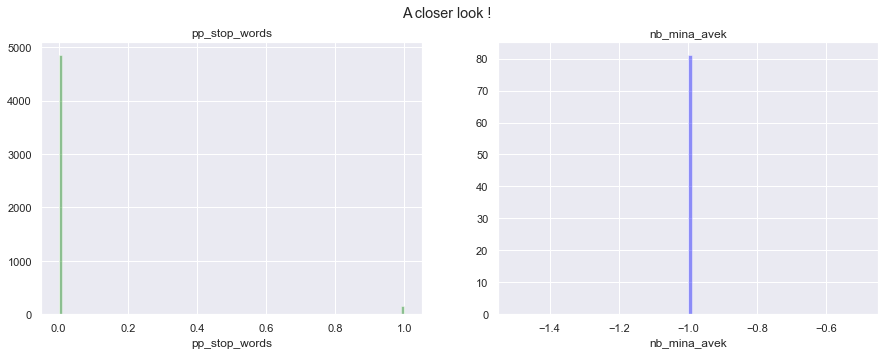

In [5]:
# Figure parameters 
sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False)
fig.suptitle('A closer look !')

# Shares distribution - Initial data
sns.distplot(X_train.pp_stop_words,
            ax=axes[0],
            color='green',
            bins=100,
            kde=False)
axes[0].set_title('pp_stop_words')

# Shares distribution - On log scale
sns.distplot(X_train[X_train.nb_mina_avek < 0].nb_mina_avek,
            ax=axes[1],
            color='blue',
            bins=100,
            kde=False)
axes[1].set_title('nb_mina_avek')

Après un regard plus près de ces deux colonnes (figure ci-dessus), nous voyons clairement les anomalies que nous venons de mentionner. Ces valeurs vont donc certainement etre réctifiés ou retirés complétement. Mais avant de prendre de telle décision, explorons tout d'abord nos données cible et leur distribution (_Prediction_) :

In [6]:
Y_train.describe()

,Prediction
count,5000.000000
mean,3216.125000
std,7840.166255
min,39.000000
25%,941.000000
50%,1403.000000
75%,2703.000000
max,208300.000000


Text(0.5, 1.0, 'nb_shares_log')

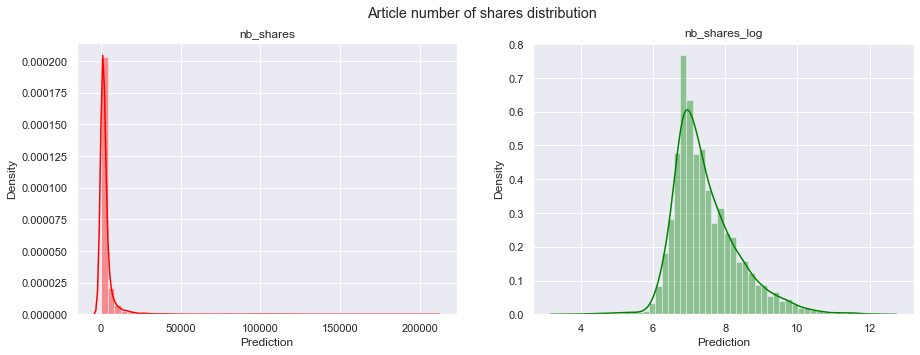

In [7]:
sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False)
fig.suptitle('Article number of shares distribution')

# Shares distribution - Initial data
sns.distplot(Y_train.Prediction,
            ax=axes[0],
            color='red')
axes[0].set_title('nb_shares')

# Shares distribution - On log scale
sns.distplot(np.log(Y_train.Prediction),
            ax=axes[1],
            color='green')
axes[1].set_title('nb_shares_log')

Nos données cible paraissent avoir une figure exponentielle, et après avor appliqué une transformation _log_, on voit que ces dérniers sont bien distribués (A normal shape) et que la plupart des données sont  contenus dans une marge bien précise (mis appart quelques valeurs trop larges mais justifiables (_viral articles_) qu'on va retirer).

Nous décidons donc de ne pas filtrer ou d'appliquer du bootstrapping sur nos données de _Prediction_.

Et vu que ces "_Predictions_" sont cohérents, nous sommes alors contraints de retirer la colonne _pp_stop_words_ mentionnée avant. Tandis que pour la colonne _nb_avea_mink_, nous transformeront toutes les valeurs négatives (que ne représentent qu'une petite proportion des données et qui n'ont qu'une seule valeur (-1)) en valeurs positives pour garder la totalité de nos données.

In [8]:
# Turning all negative values to positive
X_train["nb_mina_avek"] = abs(X_train.nb_mina_avek)

# Removing pp_stop_words
del X_train["pp_stop_words"]

# Removing outliers 
z_scores = zscore(Y_train) # calculate the z-score of the target label
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 7).all(axis=1) # get the instances index to keep

X_train = X_train[filtered_entries]
Y_train = Y_train[filtered_entries]

<AxesSubplot:>

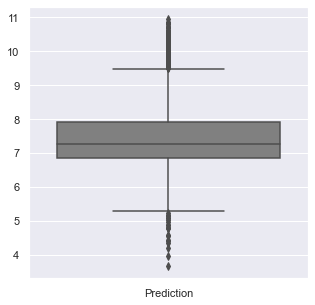

In [9]:
# Target data after filtring
plt.figure(figsize=(5,5))
sns.boxplot(data=np.log(Y_train), color="grey")

L'une des autres choses qui caractérisent nos données est la présence de quelques données catégoriques (_weekdays_ & _category_), voyons de plus près la distribution de nos données selon ces derniers :


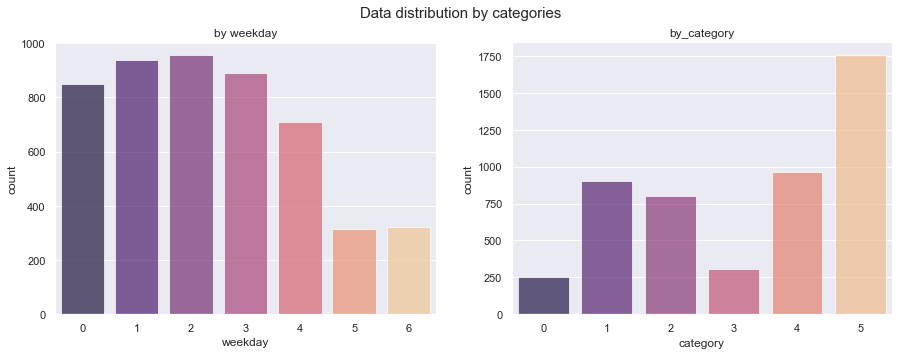

In [10]:
# A closer look on categorical Data
# styling the figure
sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False)
fig.suptitle('Article number of shares distribution')

# titling and labeling
plt.suptitle(
    "Data distribution by categories",
    fontsize=15)
axes[0].set_title('by weekday')
axes[1].set_title('by_category')
plt.ylabel("count")

# plotting
sns.countplot(x="weekday",
            alpha=.7,
            palette="magma",
            data=X_train,
            ax=axes[0])
sns.countplot(x="category",
            alpha=.7,
            palette="magma",
            data=X_train,
            ax=axes[1])

plt.show()

La distribution de nos données selon chaque catégorie parait etre distribuée de façon plutot cohérente, ce qui nous évitera d'appliquer d'autres échantillonages (Downsampling/StratifiedSampling).

Vu qu'on va faire entrainer nos données sur quelques modèles linéaires par la suite, essayons de voir si certaines corrélations linéaires existent entre nos données et notre donnée cible :

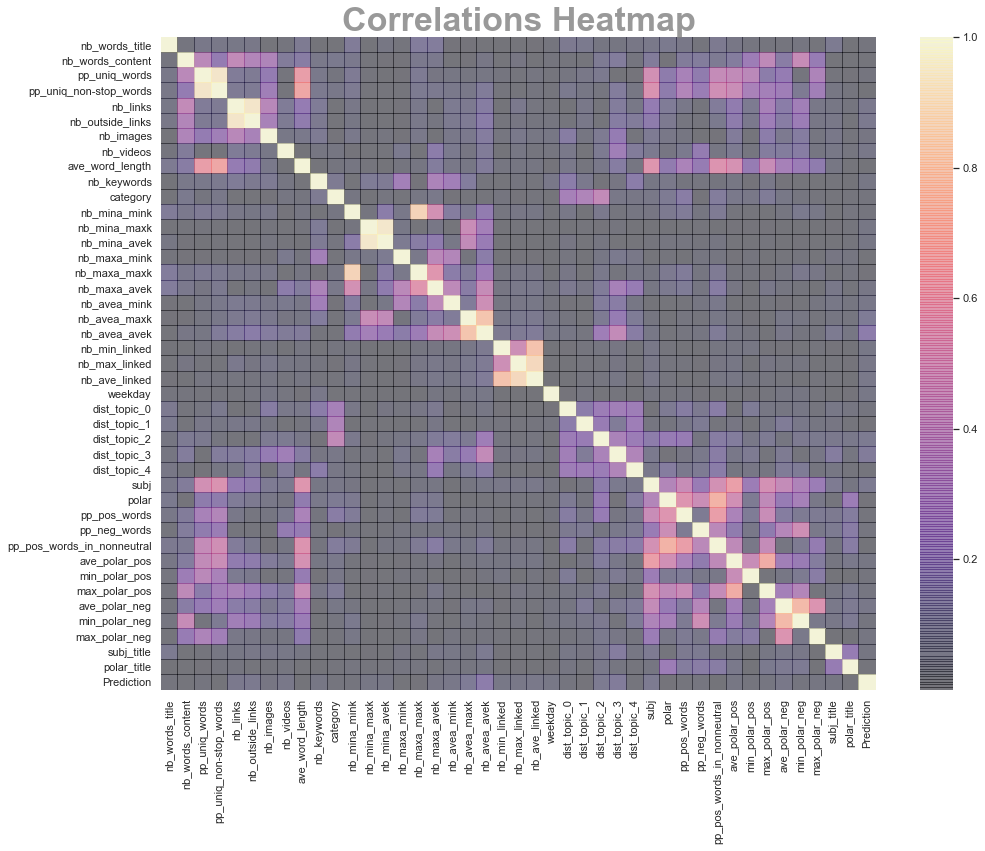

In [11]:
# calculate the correlation matrix
corr_matrix = pd.concat([X_train, Y_train], axis=1).corr()

# plot the correlation heatmap
plt.figure(figsize=(16, 12))
plt.title('Correlations Heatmap',
          fontdict={'fontsize': 34,
                    'color':  'Grey',
                    'fontweight':  'bold'},
          alpha=.8)

sns.heatmap(corr_matrix.abs(),
            cmap="magma", alpha=.5,
            xticklabels=corr_matrix.columns,
            yticklabels=corr_matrix.columns)

plt.show()

Comme la figure ci-dessus le montre, on ne voit aucune corrélation flagrante entre notre données cible et les autres données. En revanche, plusieur données sont corrélées entre eux, ces derniers nous permetteront alors de réduire la dimension de nos données en ne gardant qu'une seule pour chauque pair (ou triplet).

Le tableau ci-dessous explicite les différentes colonnes corrélées et leur niveau de corrélation (Et on choisit finalement celle qui a la plus grande variance et alors celle regroupant la plus large qté d'information) :


   feature 1 | feature 2   | Correlation   |
|:---|:------------|:-----------|
| pp_uniq_words | pp_uniq_non_stop_words  | 0.94|
| nb_links| nb_outside_links  | 0.93    |
| nb_mina_avek| nb_mina_maxk  | 0.95    |
| nb_avea_avek| nb_avea_maxk  | 0.80    |
| nb_ave_linked| nb_max_linked  | 0.88    |


In [12]:
# Columns to be deleted
labels=["nb_links",
        "pp_uniq_words",
        "nb_mina_mink",
        "nb_mina_avek",
        "nb_ave_linked",
        'subj_title']

X_train.drop(labels=labels,
    axis=1, inplace=True)

### ii.Transformation de données (_Data transformation_) :

Certains modèles de machine learning sont très sensibles vis-à-vis l'ordre de grandeur des données et ont tendance à favoriser les "features" avec le plus grand ordre de grandeur (en les jugeant comme plus importants). Il est donc necessaire pour nous, avant de procéder au choix et à l'entrainement de nos modèles, de normaliser nos données.

De plus, et comme mentionné avant, l'existance de variables catégoriques requiert un "OneHotEncoding" pour eviter toute confusion de la part du modèle de ML (en les laissant sous forme d'entiers, le modèle pourrait prendre en considération la distance entre les différents valeurs et qui en vrai n'a aucune signification)

Et finalement, nous avons appliqué une transformation logarithmiques sur un nombre de colonnes pour rendre leur distribution encore plus cohérente.

Le code ci-dessous traduit les étapes mentionnées ci-dessus :


In [13]:
# features
log_features = ["nb_words_content"]
noScale_features = ["weekday",
                    "category",
                    "polar_title"]
scale_features = [f for f in X_train.columns 
                    if (f not in noScale_features)]

# Log transformation :
X_train[log_features] = np.log1p(X_train[log_features])

# Standard Scaling :
scaler = StandardScaler()
scaler.fit(X_train[scale_features])
X_train[scale_features] = scaler.transform(X_train[scale_features])

# Categorical encoding :
for cat in ['weekday', 'category']:
    cat_data = pd.get_dummies(X_train[cat], prefix=cat, drop_first=True)
    other_data = X_train.drop([cat], axis=1)
    X_train = pd.concat([cat_data, other_data], axis=1)

Et finalement en crée une fonction qui inclut toute les transformations appliquées à nos données pour les appliquer directement à nos prochaines données à prédir :

In [14]:
def transform_data(data):
    target_data = data.copy()
    # Features
    toDelete_features=["nb_links",
            "pp_uniq_words",
            "nb_mina_mink",
            "nb_mina_avek",
            "nb_ave_linked",
            'subj_title',
            "pp_stop_words"]
    log_features = ["nb_words_content"]
    noScale_features = ["weekday",
                        "category",
                        "polar_title"]
    scale_features = [f for f in target_data.columns 
                        if (f not in (noScale_features + toDelete_features))]

    # Deleting columns
    target_data.drop(labels=toDelete_features,
        axis=1, inplace=True)

    # Log transformation :
    target_data[log_features] = np.log1p(target_data[log_features])

    # Standard Scaling :
    target_data[scale_features] = scaler.transform(target_data[scale_features])

    # Categorical encoding :
    for cat in ['weekday', 'category']:
        cat_data = pd.get_dummies(target_data[cat], prefix=cat, drop_first=True)
        other_data = target_data.drop([cat], axis=1)
        target_data = pd.concat([cat_data, other_data], axis=1)
    return target_data

## 2. Entrainement, choix et evaluation de modèles  : 

Dans cette partie, nous allons essayer de comparer un certain nombre de regresseurs on utilisant la méthode de _cross validation_ .

On commence tout d'abord par deux modèle liéaires (une version régularisée avec _Ridge_ et une version non régularisée), ensuite en evaluera d'autres modèles et le tout sans fixer leurs hyperparamètres pour avoir une idée plutot globale sur la performance de chaque modèle avant de procéder à l'optimisation de leur performance.

### i. Choix Préliminaire de modèles :

- Modèles liéaires :

In [37]:
# Linear Models :
lin_reg = TransformedTargetRegressor(regressor = Ridge(alpha=0),
                                 func=np.log,
                                 inverse_func=np.exp) # no regularization (basic linear regression)
ridge_reg = TransformedTargetRegressor(regressor = Ridge(alpha=1),
                                 func=np.log,
                                 inverse_func=np.exp) # strong regularisation

# Benchmarking :
for mod in [lin_reg, ridge_reg]:
    scores = cross_val_score(mod, X_train, Y_train, cv=5, scoring="neg_mean_squared_log_error")
    print('model : {0}\n :::: performance = {1}'.format(mod, np.sqrt(np.nanmean(-scores))))

model : TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=Ridge(alpha=0))
 :::: performance = 0.8449279135814969
model : TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=Ridge(alpha=1))
 :::: performance = 0.8448461092164097


- Modèles non linéaires :

In [38]:
# non-Linear Models :
svm_reg = TransformedTargetRegressor(regressor = SVR(kernel='poly', degree=2),
                                 func=np.log,
                                 inverse_func=np.exp) 
knn_reg = TransformedTargetRegressor(regressor = KNeighborsRegressor(),
                                 func=np.log,
                                 inverse_func=np.exp)  

# Benchmarking :
for mod in [svm_reg, knn_reg]:
    scores = cross_val_score(mod, X_train, Y_train, cv=5, scoring="neg_mean_squared_log_error")
    print('model : {0}\n :::: performance = {1}'.format(mod, np.sqrt(np.mean(-scores))))

model : TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=SVR(degree=2, kernel='poly'))
 :::: performance = 0.9439045758107101
model : TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=KNeighborsRegressor())
 :::: performance = 0.8993897225124116


- Modèles composés :

In [39]:
# Ensemble Models :
randf_reg = TransformedTargetRegressor(regressor=RandomForestRegressor(),
                                 func=np.log,
                                 inverse_func=np.exp) 
gradb_reg = TransformedTargetRegressor(regressor=GradientBoostingRegressor(),
                                 func=np.log,
                                 inverse_func=np.exp) 

# Benchmarking :
for mod in [randf_reg, gradb_reg]:
    scores = cross_val_score(mod, X_train, Y_train, cv=5, scoring="neg_mean_squared_log_error")
    print('model : {0}\n :::: performance = {1}'.format(mod, np.sqrt(np.mean(-scores))))

model : TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=RandomForestRegressor())
 :::: performance = 0.8292311415830839
model : TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=GradientBoostingRegressor())
 :::: performance = 0.8268920663688673


Après ce benchmark, il s'avère que les modèles GradientBoostingRegressor, Ridge (régularisé) et SVR (de degré 2) sont les plus performants. Le tableau suivant résume le résultat des différents modèles :

|Modèle|Performance|
|:--|:--|
|linear|0.84|
|Linear with Ridge|0.84| <- best|
|SVM (2nd degree)|0.94|
|KNN|0.90|
|Random Forest|0.83| <- best
|Gradient Boosting|0.82| <- best|

### ii. Fine-tuning : 

Nous appliquerons dans cette partie un fine-tuning pour chacun de ces modèles en utilisant une GridSearch (ou Random search) sur leur différents hyperparamètres (On choisit tout d'abord des valeurs avec des intervales grands en premier lieu, et repète le process en choisissant des paramètres au voisinages de ceux qui ont donné la performance optimale dans l'étape précédente), pour ne pas encomprer le notebook, le code suivant montre juste une étape du process:

In [ ]:
# Since the models are so close, and the data isn t huge, 
# we'll apply a grid search on each of the three most performing ones :
# Chosen models :
ridge_reg = Ridge()
gradb_reg = GradientBoostingRegressor()
randf_reg = RandomForestRegressor()

# Grid search parameters :
param_ridge = {
    'alpha': [1, 0.8, 0.4, 0.2], 
    'fit_intercept': [True, False], 
    'solver': ['svd', 'cholesky', 'lsqr', 'sag', 'saga']}
param_gradb = {'n_estimators':[50, 100, 200], 
    'learning_rate': [0.1,0.01,0.001],
    'max_depth':[2, 4, 16, 32], 
    'min_samples_leaf':[1, 3, 5, 7]}
param_randf = {'n_estimators': [500, 2000, 4500],
    'min_samples_leaf' : [1, 3, 10],
    'min_samples_split': [3, 6, 9],
    'max_depth' : [5, 11, 20]}

# Fine-tuning
models_GS_list, models_params = [gradb_reg, ridge_reg, randf_reg], [param_gradb, param_ridge, param_randf]
for model, model_params in zip(models_GS_list, models_params):
    model_GS = GridSearchCV(model, model_params, cv=5,
        scoring='neg_mean_squared_log_error',
        return_train_score=True,
        n_jobs=-1)
    model_GS.fit(X_train, np.log(Y_train))
    print('model : {0}\n :::: best parameters = {1}\n\n'.format(
                                            model, model_GS.best_params_))

In [15]:
# Fine-tuned models :
ridge_reg = TransformedTargetRegressor(
            regressor=Ridge(
                alpha=0.8,
                solver='saga'),
            func=np.log,
            inverse_func=np.exp) 
randf_reg = TransformedTargetRegressor(
            regressor=RandomForestRegressor(
                n_estimators=4500,
                min_samples_leaf=3,
                min_samples_split=6,
                max_depth=11),
            func=np.log,
            inverse_func=np.exp) 
gradb_reg = TransformedTargetRegressor(
            regressor=GradientBoostingRegressor(
                learning_rate=0.1,
                max_depth=2,
                min_samples_leaf=5,
                n_estimators=200),
            func=np.log,
            inverse_func=np.exp) 

# Benchmarking :
for mod in [randf_reg, ridge_reg, gradb_reg]:
    scores = cross_val_score(mod, X_train, Y_train, cv=5, scoring="neg_mean_squared_log_error",n_jobs=-1)
    print('model : {0}\n :::: performance = {1}'.format(mod, np.sqrt(np.mean(-scores))))

model : TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=RandomForestRegressor(max_depth=11,
                                                           min_samples_leaf=3,
                                                           min_samples_split=6,
                                                           n_estimators=4500))
 :::: performance = 0.821099238216354
model : TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=Ridge(alpha=0.8, solver='saga'))
 :::: performance = 0.8446589466587016
model : TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=GradientBoostingRegressor(max_depth=2,
                                                               min_samples_leaf=5,
                                                               n_estimators=200))
 :::: performance = 0.8205260096803901


Comme explicité dans le tableau ci-dessous, les résultats optimales qu'on a pu trouver avec la regréssion linéaire ne diffère pas beaucoup avec ce qu'on a trouvé avant mais restent meilleurs :

|Modèle|Ancienne performance| Nouvelle performance|
|:--|:--|:--|
|Linear with Ridge|0.84| 0.84|
|Random Forest|0.83| 0.82|
|Gradient Boosting|0.82| 0.82|

### iii. Réduction de dimension :

Dans cette partie, nous allons essayer de réduire la dimension de nos données tout en gardant la plus grande qté d'information/variance. Cette réduction s'avère necessaire pour pouvoir analyser encore de plus près nos données (vu que nous nous sommes rentrouvés vers la fin de leur transformation avec un nombre considérable de colonnes). Car avec un nombre grand de dimensions, et à cause du  _fléau de dimension_ , la marche d'amélioration de nos modèles est trop restreinte.

Pour ce faire, nous choisissons alors comme méthode le _Principal_Component_Analysis_ (ou PCA, qui estune sorte de projection) :

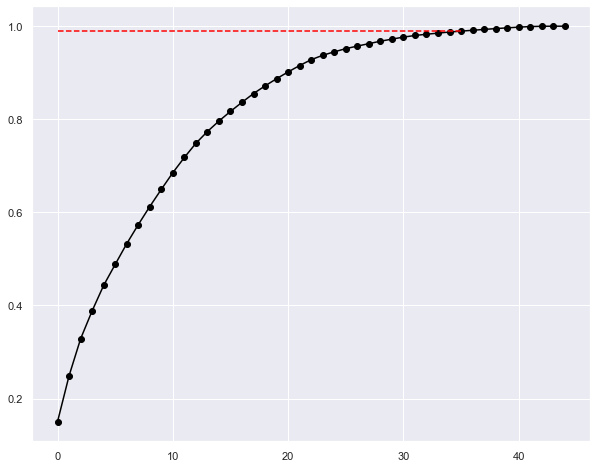

In [318]:
# PCA fitting
pca = PCA()
pca.fit(X_train)

# Cumulated variance ratio
cumsum = np.cumsum(pca.explained_variance_ratio_)

# Plotting
plt.figure(figsize=(10,8))
plt.plot(cumsum, "b-o", color="black" )
plt.plot([0.99]*36, '--', color='red')

In [319]:
# Number of dimensions that have a high variance
(pca.explained_variance_  > 1).sum()

13

A partir de la figure ci-dessus, on voit qu'avec PCA, on peut couvrir presque la totalité d'information contenue dans nos données avec seulement 36 dimensions. Et si on vois la contribution de chaque dimension dans cette qté d'information on trouve que seulement 13 ont une variance supérieur à 1. Nous essayerons alors par la suite d'appliquer une _Feature selection_ pour voir l'impact de chaque nombre de colonnes choisies sur la performance de nos meilleurs modèles :

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  45 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.5s finished
Features: 1/24[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:    0.5s finished
Features: 2/24[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  43 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:    0.7s finished
Features: 3/24[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    0.8s finished
Features: 4/24[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    0.9s finished
Features: 5/24[Parallel(n_jobs=-1)]: Using back

Text(0.5, 0.98, 'Sequential Forward Selection (w. msle')

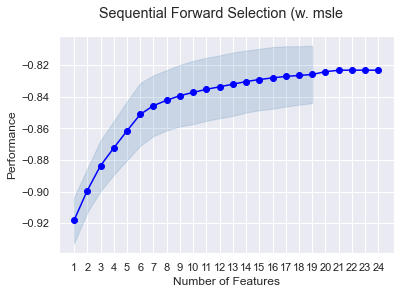

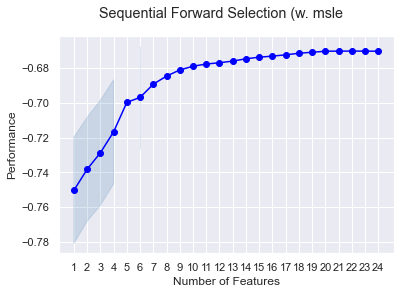

In [324]:
# Pipeline using step forward feature selection for 8-12 features
# Models
randf_reg = TransformedTargetRegressor(
            regressor=RandomForestRegressor(
                n_estimators=4500,
                min_samples_leaf=3,
                min_samples_split=6,
                max_depth=11),
            func=np.log,
            inverse_func=np.exp) 
gradb_reg = TransformedTargetRegressor(
            regressor=GradientBoostingRegressor(
                learning_rate=0.1,
                max_depth=2,
                min_samples_leaf=5,
                n_estimators=200),
            func=np.log,
            inverse_func=np.exp) 

# PCA transformation
X_train_reduced = pca.fit_transform(X_train)

# step forward selection 
sfs_randf_reg = sfs(estimator=randf_reg,
           n_jobs=-1,  # using all CPUs
           k_features=(10, 20),
           forward=True,
           floating=False,
           verbose=1,
           scoring='neg_mean_squared_log_error',
           cv=5)
sfs_gradb_reg = sfs(estimator=gradb_reg,
           n_jobs=-1,  # using all CPUs
           k_features=(10, 20),
           forward=True,
           floating=False,
           verbose=1,
           scoring='neg_mean_squared_log_error',
           cv=5)

# fitting the sfs
sfs_randf_reg.fit(X_train_reduced, Y_train)
sfs_gradb_reg.fit(X_train_reduced, Y_train)

# visualizing the selection performance
# For ridge regression
plot_sfs(sfs_gradb_reg.get_metric_dict(), kind='std_err')
plt.suptitle('Sequential Forward Selection (w. msle')

# for Support vector machine regressor
plot_sfs(sfs_randf_reg.get_metric_dict(), kind='std_err')
plt.suptitle('Sequential Forward Selection (w. msle')

Nous constatons que la performance de nos deux modèles augmente de façon exponentielle au début mais stagne après 14 paramètres. Ceci dit, nous déduisons que ces 14 paramètres détiennent le plus grand pourcentage d'information initiale.

Entrainons maintenant nos deux modèles sur ces 14 paramètres seulement et comparons les aux résultats trouvés précédemment (sans PCA) :

In [20]:
# Transforming the data
pca = PCA(n_components=14)
X_train_to14 = pca.fit_transform(X_train)

# Models :
randf_reg = TransformedTargetRegressor(
            regressor=RandomForestRegressor(
                n_estimators=4500,
                min_samples_leaf=3,
                min_samples_split=6,
                max_depth=11),
            func=np.log,
            inverse_func=np.exp) 
gradb_reg = TransformedTargetRegressor(
            regressor=GradientBoostingRegressor(
                learning_rate=0.1,
                max_depth=2,
                min_samples_leaf=5,
                n_estimators=200),
            func=np.log,
            inverse_func=np.exp) 

# Results :
for mod in [randf_reg, gradb_reg]:
    scores = cross_val_score(mod, X_train_to14, Y_train, cv=5, scoring="neg_mean_squared_log_error", n_jobs=-1)
    print('model : {0}\n :::: performance = {1}'.format(mod, np.sqrt(-scores).mean()))

model : TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=RandomForestRegressor(max_depth=11,
                                                           min_samples_leaf=3,
                                                           min_samples_split=6,
                                                           n_estimators=4500))
 :::: performance = 0.8416939914473902
model : TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=GradientBoostingRegressor(max_depth=2,
                                                               min_samples_leaf=5,
                                                               n_estimators=200))
 :::: performance = 0.8486123496339616


Nous arrivons à avoir une performance qui est plutot proche à celle des modèles non réduits, par contre ces denrniers restent toujours meilleurs. Nous utiliserons donc nos modèles non réduits pour les prédictions finales (à soumettre).

Mais avant de passer aux prédictions finales, essayons de créer un modèle hybride (constitué des deux modèles choisis), pour cela nous utiliserons un algorithm de vote :

In [21]:
# Sub-models
randf_reg = TransformedTargetRegressor(
            regressor=RandomForestRegressor(
                n_estimators=4500,
                min_samples_leaf=3,
                min_samples_split=6,
                max_depth=11),
            func=np.log,
            inverse_func=np.exp) 
gradb_reg = TransformedTargetRegressor(
            regressor=GradientBoostingRegressor(),
            func=np.log,
            inverse_func=np.exp)

# Voting model
vote_reg = VotingRegressor(
    estimators=[('lr', gradb_reg), ('svr', randf_reg)])
# Results
scores = cross_val_score(vote_reg, X_train, Y_train, cv=5, scoring="neg_mean_squared_log_error", n_jobs=-1)
print('model : {0}\n :::: performance = {1}'.format(vote_reg, np.sqrt(-scores).mean()))


model : VotingRegressor(estimators=[('lr',
                             TransformedTargetRegressor(func=<ufunc 'log'>,
                                                        inverse_func=<ufunc 'exp'>,
                                                        regressor=GradientBoostingRegressor())),
                            ('svr',
                             TransformedTargetRegressor(func=<ufunc 'log'>,
                                                        inverse_func=<ufunc 'exp'>,
                                                        regressor=RandomForestRegressor(max_depth=11,
                                                                                        min_samples_leaf=3,
                                                                                        min_samples_split=6,
                                                                                        n_estimators=4500)))])
 :::: performance = 0.8203998347997071


Le modèle hybride s'avère encore plus performant que les deux modèles, ce qui est évident, mais pas de manière remarquable (de l'ordre de 0.003).

Nous resumons finalement les différents résultats de ce benchmark dans le tableau ci-dessous :


|Modèle|performance| 
|:--|--:|
|Voting regressor| 0.82|
|Random Forest |0.82| <- chosen
|Gradient Boosting |0.82|
|Random Forest (PCA)|0.84|
|Gradient Boosting (PCA)|0.84|
|Ridge regressor |0.84|


## Prédiction :

On transforme finalement nos données de prédiction et on utilise le modèle choisi (le Random forest) pour faire nos prédictions :

In [20]:
# Final model :
final_model = TransformedTargetRegressor(
    regressor=RandomForestRegressor(
        n_estimators=4500,
        min_samples_leaf=3,
        min_samples_split=6,
        max_depth=11),
    func=np.log,
    inverse_func=np.exp) 

# Fitting the model :
final_model.fit(X_train, Y_train)

# Transforming the targeted data :
X_test_f = transform_data(X_test)

# Making predictions :
predictions = final_model.predict(X_test_f)

# to a dataFrame 
predictions_df = pd.DataFrame((predictions).astype(int))
predictions_df.columns = ["Prediction"]

In [21]:
# Saving the data ..
predictions_df.to_csv("submission.csv",sep= '-', header=True)

In [22]:
# Results
predictions_df

,Prediction
0,1735
1,2093
2,1520
3,2006
4,2635
...,...
1995,2098
1996,1036
1997,1885
1998,1353
